In [75]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from PIL import Image, ImageDraw
from tqdm import tqdm
from typing import List
import mercury as mr
import cv2

from sklearn.preprocessing import StandardScaler

from MirrorExtractor.mirror_extractor import MirrorExtractor
from MirrorFeatureExtractor.mirror_feature_extractor import MirrorFeatureExtractor

In [72]:
def extract_polygon_region_cv2(img_array, pts):
    img = img_array
    pts = pts.reshape((-1, 1, 2))
            
    # Create a mask with the same shape as the image (1 channel)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [pts], color=255)
            
    # Apply mask to image
    masked_img = cv2.bitwise_and(img, img, mask=mask)
            
    # Find bounding rectangle and crop
    x, y, w, h = cv2.boundingRect(pts)
    cropped = masked_img[y:y+h, x:x+w]
    cropped_gray = rgb_to_gray(cropped)
    return cropped_gray

RGB_TO_GRAY = np.array([0.299, 0.587, 0.114])

def rgb_to_gray(img_rgb: np.ndarray) -> np.ndarray:
    """Konwersja RGB do skali szarośći metodą weighted average"""
    return np.dot(img_rgb[..., :3], RGB_TO_GRAY).astype(np.uint8)


def get_diff_all_features(img_path_1, img_path_2):
    mirrors_list_1 = get_mirrors_img_list(img_path_1)
    mirrors_list_2 = get_mirrors_img_list(img_path_2)
    
    distances = []
    feature_diffs = []
    
    for mirror_idx, (img_a, img_b) in enumerate(zip(mirrors_list_1, mirrors_list_2)):
        f_a = get_texture_feat(img_a)
        f_b = get_texture_feat(img_b)
        
        # Zamień słowniki na wektory
        vec_a = np.array(list(f_a.values()))
        vec_b = np.array(list(f_b.values()))
        
        feature_diffs.append({
            'mirror_idx': mirror_idx,
            'vec_a': vec_a,
            'vec_b': vec_b,
            'feature_names': list(f_a.keys())
        })
    
    # Normalizacja - ważne bo cechy mają różne skale!
    all_vecs = np.vstack([fd['vec_a'] for fd in feature_diffs] + 
                         [fd['vec_b'] for fd in feature_diffs])
    scaler = StandardScaler()
    scaler.fit(all_vecs)
    
    # Oblicz znormalizowane odległości
    for fd in feature_diffs:
        vec_a_norm = scaler.transform([fd['vec_a']])[0]
        vec_b_norm = scaler.transform([fd['vec_b']])[0]
        
        # Odległość euklidesowa
        distance = np.linalg.norm(vec_a_norm - vec_b_norm)
        fd['distance'] = distance
        fd['diff_vector'] = vec_a_norm - vec_b_norm
    
    return feature_diffs

def get_texture_feat(gray_img):
    feat_extractor = MirrorFeatureExtractor()
    gray_norm = cv2.normalize(gray_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    feat_dict = feat_extractor.extract_texture_features(gray_norm)
    return feat_dict

def get_mirrors_img_list(img_path):
    img = Image.open(img_path)
    img_array = np.array(img)
    mirror_img_list = []
    for key in data['mirror_ids'].keys():
        points = data['mirror_ids'][key]
        crop = extract_polygon_region_cv2(img_array, np.array(points))
        mirror_img_list.append(crop)
    return mirror_img_list

def find_outlier_mirrors(feature_diffs, n_top=5):
    """Znajdź lustra najbardziej odstające."""
    # Sortuj po odległości malejąco
    sorted_mirrors = sorted(feature_diffs, key=lambda x: x['distance'], reverse=True)
    
    print("=== Lustra najbardziej odstające ===")
    for i, mirror in enumerate(sorted_mirrors[:n_top]):
        print(f"\n#{i+1} Lustro {mirror['mirror_idx']}: distance = {mirror['distance']:.4f}")
        
        # Pokaż które cechy najbardziej się różnią
        diff = np.abs(mirror['diff_vector'])
        top_feat_idx = np.argsort(diff)[::-1][:3]
        print("   Największe różnice w cechach:")
        for idx in top_feat_idx:
            print(f"   - {mirror['feature_names'][idx]}: {diff[idx]:.4f}")
    
    return sorted_mirrors

In [10]:
BASE_DIR = "/home/pgliwny/Praca/Computer_vision_for_MAGIC/"
img_path = os.path.join(BASE_DIR, "data/data/2025/12/15/IRCamM1T20251215_122547M.jpg")

In [12]:
mirror_points_path = os.path.join(BASE_DIR, "data/points_IRCam.json")
with open(mirror_points_path, 'r') as f:
    data = json.load(f)

In [14]:
img = Image.open(img_path)

In [15]:
points_72 = data['mirror_ids']['id_072']

In [19]:
points_72

[[763, 453], [858, 452], [855, 548], [759, 549], [763, 453]]

In [33]:
crop = extract_polygon_region_cv2(np.array(img), np.array(points_72))

In [34]:
crop.shape

(98, 100)

In [31]:
rgb_to_gray(crop).shape

(98, 100)

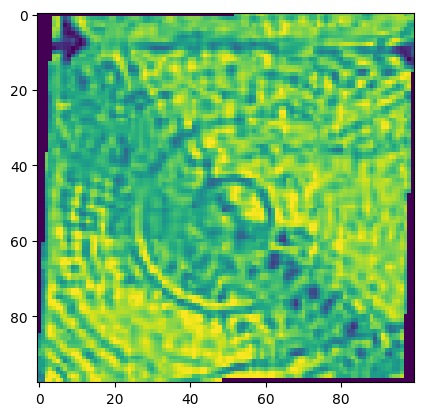

In [35]:
plt.imshow(crop)

In [39]:
BASE_DIR = "/home/pgliwny/Praca/Computer_vision_for_MAGIC/"
img_path = os.path.join(BASE_DIR, "data/data/2025/12/15/IRCamM1T20251215_122547M.jpg")

mirrors_img_list = get_mirrors_img_list(img_path)

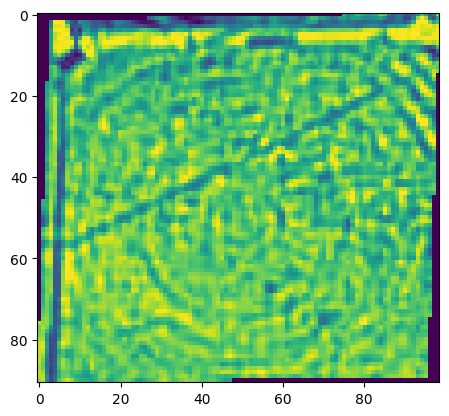

In [41]:
plt.imshow(mirror_img_list[55])

In [46]:
def mark_mirror(mirror_points_path, mirror_id_list, img):
    with open(mirror_points_path, 'r') as f:
        data = json.load(f)

    draw = ImageDraw.Draw(img)
    for m_id in mirror_id_list:
        points = data['mirror_ids'][f'id_{m_id}']
        draw.polygon(points, outline="red", width=10)
    

In [66]:
img_path1 = os.path.join(BASE_DIR, "data/data/2025/12/15/IRCamM1T20251215_081547M.jpg")
img_path2 = os.path.join(BASE_DIR, "data/data/2025/12/15/IRCamM1T20251215_082547M.jpg")
output_diff = get_diff_all_features(img_path1, img_path2)

In [73]:
o=find_outlier_mirrors(output_diff,  n_top=10)

=== Lustra najbardziej odstające ===

#1 Lustro 244: distance = 7.2391
   Największe różnice w cechach:
   - glcm_homogeneity: 3.9084
   - lbp_mean: 3.9015
   - lbp_entropy: 3.5730

#2 Lustro 220: distance = 6.0703
   Największe różnice w cechach:
   - glcm_homogeneity: 3.3187
   - lbp_mean: 2.8776
   - glcm_correlation: 2.5325

#3 Lustro 222: distance = 5.8867
   Największe różnice w cechach:
   - glcm_homogeneity: 3.0271
   - lbp_mean: 2.7408
   - glcm_correlation: 2.4472

#4 Lustro 235: distance = 5.5049
   Największe różnice w cechach:
   - glcm_homogeneity: 2.8466
   - lbp_mean: 2.6803
   - glcm_dissimilarity: 2.2735

#5 Lustro 219: distance = 4.8972
   Największe różnice w cechach:
   - glcm_correlation: 2.5342
   - glcm_homogeneity: 2.5024
   - lbp_mean: 2.4557

#6 Lustro 221: distance = 3.8303
   Największe różnice w cechach:
   - glcm_homogeneity: 2.1735
   - lbp_mean: 1.9791
   - glcm_correlation: 1.6564

#7 Lustro 189: distance = 3.1698
   Największe różnice w cechach:
   - 

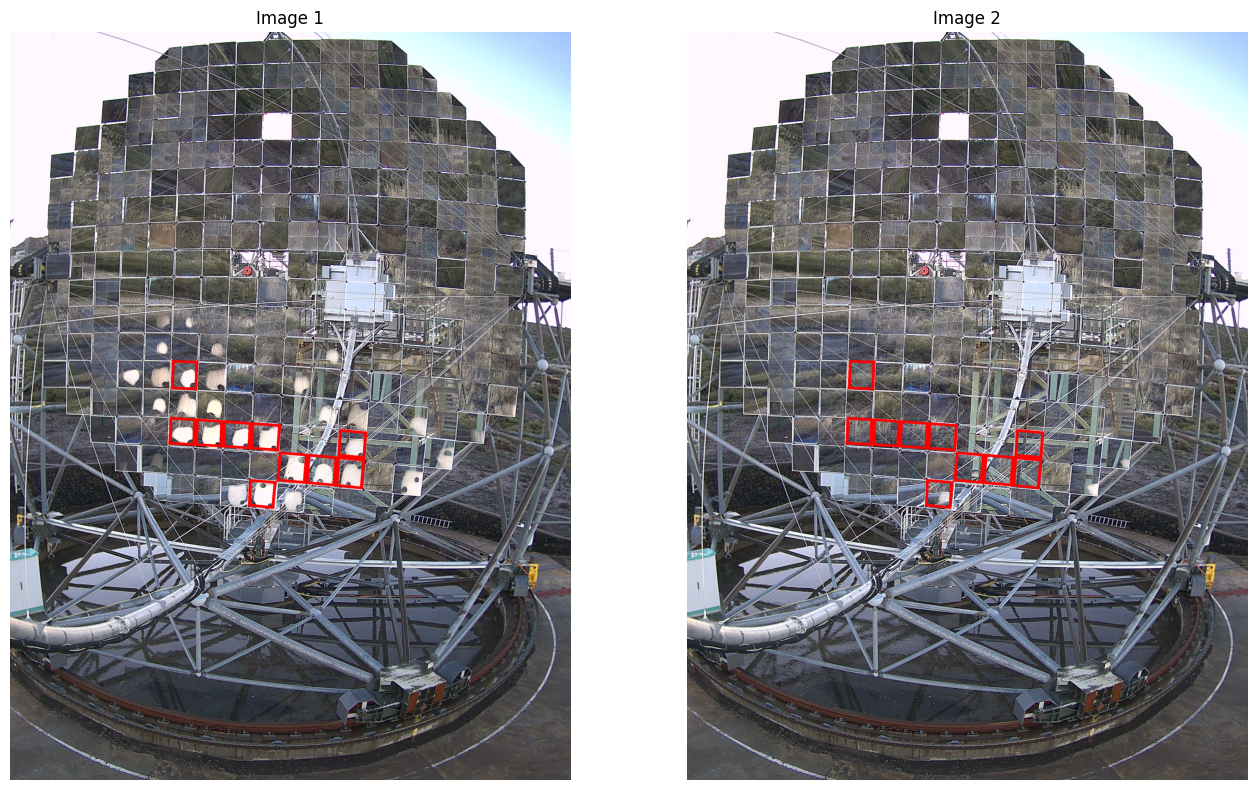

In [74]:
mirror_mark_list = ["244", "220", "222", "235", "219", "221", "189", "236", "237", "225"]
img1 = Image.open(img_path1)
mark_mirror(mirror_points_path, mirror_mark_list, img1)
img2 = Image.open(img_path2)
mark_mirror(mirror_points_path, mirror_mark_list, img2)

fig, axes = plt.subplots(1, 2, figsize=(14, 8))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Image 1')

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Image 2')

plt.tight_layout()
plt.show()

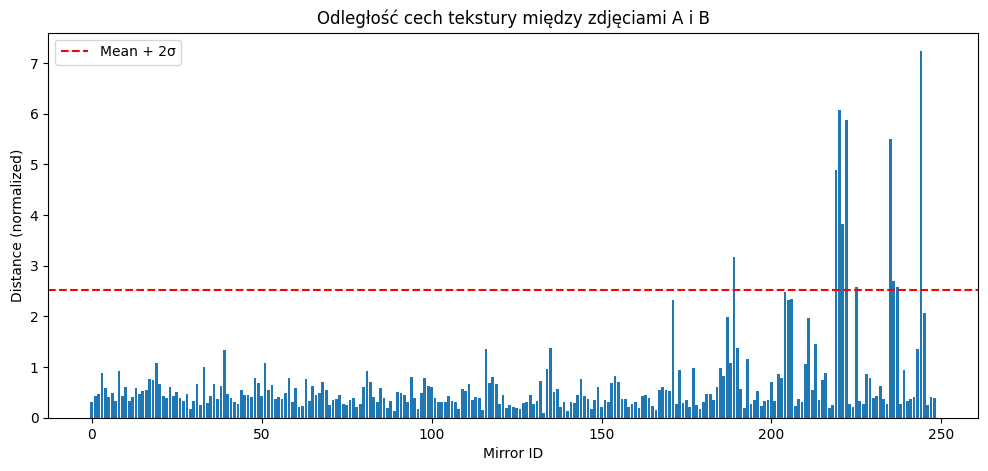

In [69]:
distances = [fd['distance'] for fd in output_diff]
mirror_ids = [fd['mirror_idx'] for fd in output_diff]

plt.figure(figsize=(12, 5))
plt.bar(mirror_ids, distances)
plt.axhline(np.mean(distances) + 2*np.std(distances), color='r', 
            linestyle='--', label='Mean + 2σ')
plt.xlabel('Mirror ID')
plt.ylabel('Distance (normalized)')
plt.title('Odległość cech tekstury między zdjęciami A i B')
plt.legend()
plt.show()